In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import re

from IPython.core.display import HTML, display
%matplotlib inline
plt.style.use('bmh') # prettier plots
plt.rcParams['figure.figsize'] = (8, 6)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10
display(HTML("<style>.container { width:90% !important; }</style>"))


# Show a simple scatter plot

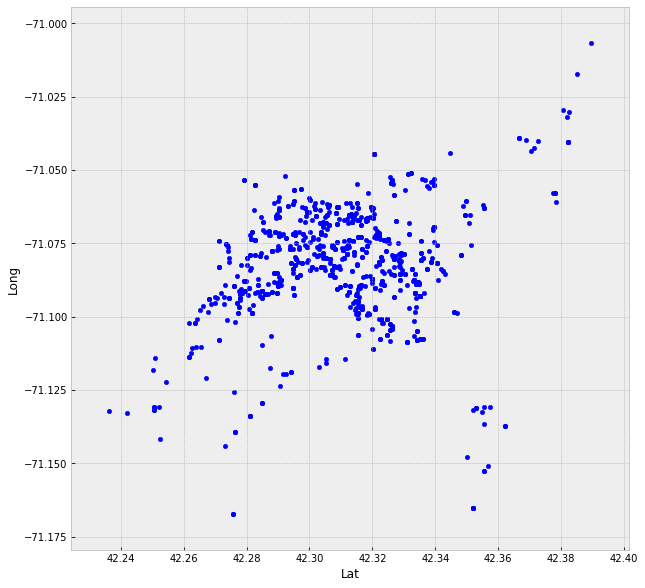

In [2]:
df = pd.read_csv('datasets/boston_sample.csv')
df = df.loc[df['Lat'] > 40]
df = df.loc[df['Long'] < 70]
df.plot.scatter(x='Lat', y='Long', figsize=(10,10));

# Use geopandas world or USA maps to show scatter over map

Automatically detect if all points are within continental USA and plot only USA map (this requires the folder `us-states-cartographic-boundary-shapefiles`) to work

In [3]:
import geopandas
from shapely import speedups
from shapely.geometry import Point
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

speedups.enable()

def plot_df(ax, df, x, y, title, force_world_map=False):
    
    def all_all_points_in_usa(seq):
        """Expects a iterator to lat, lon tuples"""
        top = 49.3457868 # north lat
        left = -124.7844079 # west long
        right = -66.9513812 # east long
        bottom =  24.7433195 # south lat
        return all(bottom <= y <= top and left <= x <= right for x, y in seq)

    
    def all_points_witin_state(seq, states):
        """returns state abbr if all points in the sequence of lat/lon are contained by a state else None"""
        for state in states.STUSPS:
            poly = states[states.STUSPS == state].geometry.tolist()[0]
            if all([poly.contains(Point(x, y)) for x, y in seq]):
                return str(state)
            
        return None

    def outlier_detection(df, x, y, z_score_threshold=3):
        """returns inliers, outliers. Outlier is defined as either x or y are outside of z score"""
        df_source = df[[x,y]]
        outlier_index = np.abs(stats.zscore(df_source)) > z_score_threshold
        df_outliers = df_source[outlier_index.any(axis=1)]
        df_inliers = df_source[np.invert(outlier_index).all(axis=1)]
        return df_inliers, df_outliers

    df_inliers, df_outliers = outlier_detection(df, x, y)
    
    gdf = geopandas.GeoDataFrame(df_inliers, geometry=geopandas.points_from_xy(df_inliers[x], df_inliers[y]))
    gdf_outliers = geopandas.GeoDataFrame(df_outliers, geometry=geopandas.points_from_xy(df_outliers[x], df_outliers[y]))

    seq = list(zip(df[x], df[y]))[:1000]
    
    if not force_world_map and all_all_points_in_usa(seq):
        states = geopandas.read_file("geo_data/us-states-cartographic-boundary-shapefiles/cb_2016_us_state_500k.shp")
        states = states[states.STATEFP.astype(int) < 60]
        states = states[~states.NAME.isin(['Hawaii', 'Alaska'])]
        
        one_state = all_points_witin_state(seq, states)
        if one_state:
            ax = states[states.STUSPS == one_state].plot(ax=ax, color='lightgrey', linewidth=0.5, edgecolor='white')
            ax.set_title("{} ({})".format(title, one_state))
        else:
            ax = states.plot(ax=ax, color='lightgrey', linewidth=0.5, edgecolor='white')
            ax.set_title("{} ({})".format(title, "USA ONLY"))
    else:
        world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
        ax = world.plot(ax=ax, color='lightgrey', linewidth=0.5, edgecolor='white')
        ax.set_title("{}".format(title), fontsize=25)

    markersize = 1 if len(x) > 100 else 10  
    gdf.plot(ax=ax, color='blue', markersize=markersize)
    if len(gdf_outliers):
        gdf_outliers.plot(ax=ax, color='red', markersize=markersize)

    #ax.axis('off')
    ax.set_facecolor('#ffffff')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')



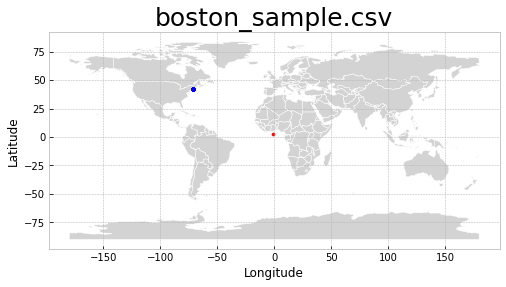

In [4]:
ds = 'boston_sample.csv'
df = pd.read_csv('datasets/{}'.format(ds)).sample(1000)
fig, ax = plt.subplots(figsize=(10,4))
plot_df(ax, df, x='Long', y='Lat', title=ds)


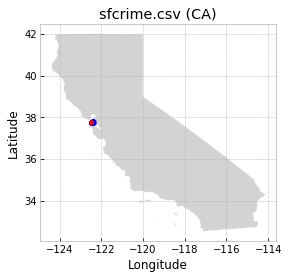

In [5]:
ds = 'sfcrime.csv'
df = pd.read_csv('datasets/{}'.format(ds)).sample(1000)
fig, ax = plt.subplots(figsize=(10,4))
plot_df(ax, df, x='X', y='Y', title=ds)

## Show how to map a regex onto a single column in a df and parse out sequences for x and y, then put those into a new dataframe and plot

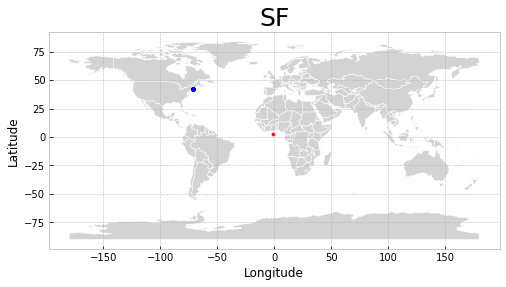

In [6]:
df = pd.read_csv('datasets/boston_sample.csv').sample(1000)

def parse_column_to_x_y_df(df, gis_col):

    pat = re.compile(r"^[(\[]?(\-?\d+\.\d+?),\s*(\-?\d+\.\d+?)[)\]]?$")
    lats, lons = zip(*df.dropna()[gis_col].apply(lambda v: pat.search(v).groups()))

    return pd.DataFrame({
        "X": lons,
        "Y": lats
    }).astype({'X':'float64', 'Y':'float64'})


fig, ax = plt.subplots(figsize=(10,4))
plot_df(ax, parse_column_to_x_y_df(df, 'Location'), x='X', y='Y', title="SF")


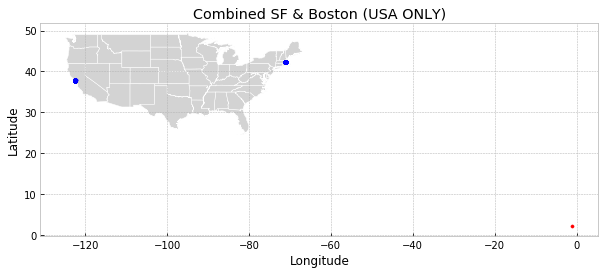

In [7]:
df_sf = pd.read_csv('datasets/sfcrime.csv').sample(1000).rename({'X':'Long', 'Y':'Lat'}, axis=1)[['Long', 'Lat']]
df_ma = pd.read_csv('datasets/boston_sample.csv').sample(1000)[['Long', 'Lat']]
df = pd.concat([df_sf, df_ma]).sample(frac=1)
fig, ax = plt.subplots(figsize=(10,4))
plot_df(ax, df, x='Long', y='Lat', title="Combined SF & Boston")


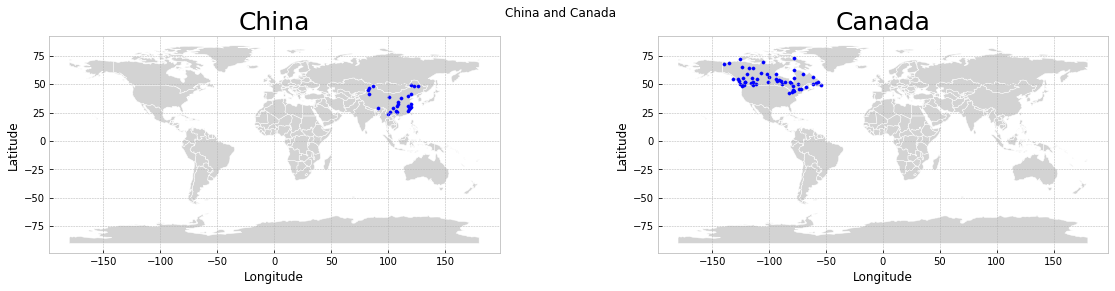

In [8]:

df = pd.read_csv('datasets/airports.csv', low_memory=False).dropna().sample(1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle('China and Canada')

plot_df(ax1, df.loc[df['Country'] == 'China'],  x='Long', y='Lat', title='China')
plot_df(ax2, df.loc[df['Country'] == 'Canada'], x='Long', y='Lat', title='Canada')

## Experiment with mapping options

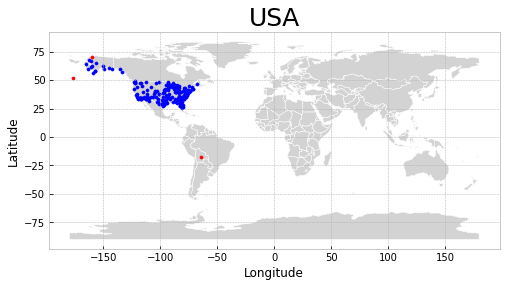

In [9]:
df = pd.read_csv('datasets/airports.csv', low_memory=False).dropna().sample(1000)
fig, ax = plt.subplots(figsize=(10,4))
plot_df(ax, df.loc[df['Country'] == 'United States'],  x='Long', y='Lat', title='USA')


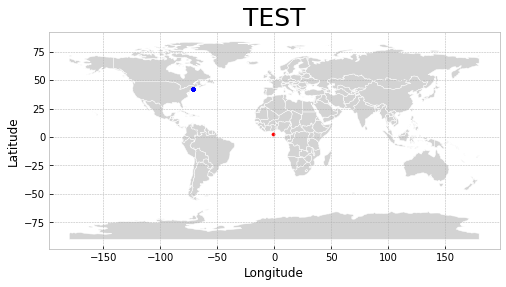

In [10]:
df = pd.read_csv('datasets/boston_sample.csv')
fig, ax = plt.subplots(figsize=(10,4))
plot_df(ax, df,  x='Long', y='Lat', title='TEST', force_world_map=True)
